In [34]:
#!pip install spotipy

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
secrets_file = open("untitled.txt","r")
string = secrets_file.read()

In [3]:
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        #print(line.split(':'))
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

In [4]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [35]:
sp

In [5]:
string

'clientid:fa739367705d45608a57115af15850ab\nclientsecret:d0f01d3343a348a08d14ec773e60367c'

In [6]:
from random import randint
from time import sleep
def get_playlist_tracks(playlist_id):
    results = sp.user_playlist_tracks("spotify",playlist_id)
    tracks = results['items']
    while results['next']!=None:
        results = sp.next(results)
        tracks = tracks + results['items']
        sleep(randint(1,1000)/1000) # respectful nap
    return tracks

In [7]:
all_tracks = get_playlist_tracks("6yPiKpy7evrwvZodByKvM9")
len(all_tracks)

10000

In [8]:
import pandas as pd
from pandas import json_normalize

In [9]:
tracks = json_normalize(all_tracks)
artists_df = pd.DataFrame(columns=['href', 'id', 'name', 'type', 'uri', 'external_urls.spotify','song_id', 'song_name', 'popularity' ])
for i in tracks.index:
    artists_for_song = json_normalize(tracks.iloc[i]['track.artists'])
    artists_for_song['song_id']    = tracks.iloc[i]['track.id']         # we want to keep song_id, it is the sae for all artists
    artists_for_song['song_name']  = tracks.iloc[i]['track.name']       # we want to keep song_name, it is the sae for all artists
    artists_for_song['popularity'] = tracks.iloc[i]['track.popularity'] # same for popularity
    artists_df = pd.concat([artists_df, artists_for_song], axis=0)

In [10]:
df_final = artists_df[['song_name', 'name', 'song_id', 'popularity']].reset_index(drop=True)
df_final

,song_name,name,song_id,popularity
0,2K,Nosaj Thing,33xMbeHzmWd6Od0BmLZEUs,0
1,4 Billion Souls,The Doors,3UnyplmZaq547hwsfOR5yy,26
2,4 Minute Warning,Radiohead,1w8QCSDH4QobcQeT4uMKLm,0
3,7 Element,Vitas,7J9mBHG4J2eIfDAv5BehKA,0
4,#9 Dream,R.E.M.,1VZedwJj1gyi88WFRhfThb,6
...,...,...,...,...
11848,London Calling - Remastered,The Clash,5jzma6gCzYtKB1DbEwFZKH,75
11849,Low Rider,War,2fmMPJb5EzZCx8BcNJvVk4,0
11850,Flower,Moby,60rIdEPDrzyLiLC0icp3xz,0
11851,Brighter Than Gold,The Cat Empire,0sEm1ld0V8YTCPcjPVfIsc,47


In [11]:
df_final.dropna(inplace=True)
chunks = [(i, i+100) for i in range(0, len(df_final), 100)]
audio_features_list = []
for chunk in chunks:
    id_list100 = df_final['song_id'][chunk[0]:chunk[1]]
    audio_features_list = audio_features_list + sp.audio_features(id_list100)
    sleep(randint(1,3000)/1000)
len(audio_features_list)

11771

In [34]:
audio_features_list

[{'danceability': 0.31,
  'energy': 0.445,
  'key': 7,
  'loudness': -13.355,
  'mode': 0,
  'speechiness': 0.0863,
  'acousticness': 0.094,
  'instrumentalness': 0.0678,
  'liveness': 0.113,
  'valence': 0.122,
  'tempo': 95.36,
  'type': 'audio_features',
  'id': '33xMbeHzmWd6Od0BmLZEUs',
  'uri': 'spotify:track:33xMbeHzmWd6Od0BmLZEUs',
  'track_href': 'https://api.spotify.com/v1/tracks/33xMbeHzmWd6Od0BmLZEUs',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/33xMbeHzmWd6Od0BmLZEUs',
  'duration_ms': 152560,
  'time_signature': 3},
 {'danceability': 0.419,
  'energy': 0.565,
  'key': 5,
  'loudness': -11.565,
  'mode': 1,
  'speechiness': 0.0347,
  'acousticness': 0.137,
  'instrumentalness': 0.337,
  'liveness': 0.128,
  'valence': 0.648,
  'tempo': 151.277,
  'type': 'audio_features',
  'id': '3UnyplmZaq547hwsfOR5yy',
  'uri': 'spotify:track:3UnyplmZaq547hwsfOR5yy',
  'track_href': 'https://api.spotify.com/v1/tracks/3UnyplmZaq547hwsfOR5yy',
  'analysis_url': 'https://ap

In [12]:
audio_features_df = pd.DataFrame(audio_features_list)
audio_features_df.drop_duplicates(inplace=True)
df_w_audio_ft = pd.merge(left=df_final,
                        right=audio_features_df,
                        how='inner',
                        left_on='song_id',
                        right_on='id')
df_w_audio_ft

,song_name,name,song_id,popularity,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,2K,Nosaj Thing,33xMbeHzmWd6Od0BmLZEUs,0,0.310,0.445,7,-13.355,0,0.0863,...,0.1130,0.122,95.360,audio_features,33xMbeHzmWd6Od0BmLZEUs,spotify:track:33xMbeHzmWd6Od0BmLZEUs,https://api.spotify.com/v1/tracks/33xMbeHzmWd6...,https://api.spotify.com/v1/audio-analysis/33xM...,152560,3
1,4 Billion Souls,The Doors,3UnyplmZaq547hwsfOR5yy,26,0.419,0.565,5,-11.565,1,0.0347,...,0.1280,0.648,151.277,audio_features,3UnyplmZaq547hwsfOR5yy,spotify:track:3UnyplmZaq547hwsfOR5yy,https://api.spotify.com/v1/tracks/3UnyplmZaq54...,https://api.spotify.com/v1/audio-analysis/3Uny...,197707,4
2,4 Minute Warning,Radiohead,1w8QCSDH4QobcQeT4uMKLm,0,0.354,0.302,9,-13.078,1,0.0326,...,0.1110,0.223,123.753,audio_features,1w8QCSDH4QobcQeT4uMKLm,spotify:track:1w8QCSDH4QobcQeT4uMKLm,https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...,https://api.spotify.com/v1/audio-analysis/1w8Q...,244285,4
3,7 Element,Vitas,7J9mBHG4J2eIfDAv5BehKA,0,0.727,0.785,5,-6.707,0,0.0603,...,0.3100,0.960,129.649,audio_features,7J9mBHG4J2eIfDAv5BehKA,spotify:track:7J9mBHG4J2eIfDAv5BehKA,https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...,https://api.spotify.com/v1/audio-analysis/7J9m...,249940,4
4,#9 Dream,R.E.M.,1VZedwJj1gyi88WFRhfThb,6,0.571,0.724,0,-5.967,1,0.0260,...,0.0919,0.385,116.755,audio_features,1VZedwJj1gyi88WFRhfThb,spotify:track:1VZedwJj1gyi88WFRhfThb,https://api.spotify.com/v1/tracks/1VZedwJj1gyi...,https://api.spotify.com/v1/audio-analysis/1VZe...,278320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11766,London Calling - Remastered,The Clash,5jzma6gCzYtKB1DbEwFZKH,75,0.651,0.801,0,-7.340,1,0.0514,...,0.0825,0.776,133.769,audio_features,5jzma6gCzYtKB1DbEwFZKH,spotify:track:5jzma6gCzYtKB1DbEwFZKH,https://api.spotify.com/v1/tracks/5jzma6gCzYtK...,https://api.spotify.com/v1/audio-analysis/5jzm...,200480,4
11767,Low Rider,War,2fmMPJb5EzZCx8BcNJvVk4,0,0.811,0.647,0,-10.989,1,0.0498,...,0.0572,0.990,139.787,audio_features,2fmMPJb5EzZCx8BcNJvVk4,spotify:track:2fmMPJb5EzZCx8BcNJvVk4,https://api.spotify.com/v1/tracks/2fmMPJb5EzZC...,https://api.spotify.com/v1/audio-analysis/2fmM...,191560,4
11768,Flower,Moby,60rIdEPDrzyLiLC0icp3xz,0,0.686,0.610,7,-5.902,1,0.0262,...,0.0710,0.766,80.567,audio_features,60rIdEPDrzyLiLC0icp3xz,spotify:track:60rIdEPDrzyLiLC0icp3xz,https://api.spotify.com/v1/tracks/60rIdEPDrzyL...,https://api.spotify.com/v1/audio-analysis/60rI...,206293,4
11769,Brighter Than Gold,The Cat Empire,0sEm1ld0V8YTCPcjPVfIsc,47,0.711,0.718,6,-5.739,1,0.0380,...,0.0732,0.688,117.071,audio_features,0sEm1ld0V8YTCPcjPVfIsc,spotify:track:0sEm1ld0V8YTCPcjPVfIsc,https://api.spotify.com/v1/tracks/0sEm1ld0V8YT...,https://api.spotify.com/v1/audio-analysis/0sEm...,200293,4


In [13]:
df_w_audio_ft.to_csv('df_w_audio_ft.csv', index=False)

# Lab | Unsupervised learning intro (GNOD - part 4)


In [14]:
import pandas as pd
#from sklearn import datasets

data = pd.read_csv("df_w_audio_ft.csv")

In [15]:
data

,song_name,name,song_id,popularity,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,2K,Nosaj Thing,33xMbeHzmWd6Od0BmLZEUs,0,0.310,0.445,7,-13.355,0,0.0863,...,0.1130,0.122,95.360,audio_features,33xMbeHzmWd6Od0BmLZEUs,spotify:track:33xMbeHzmWd6Od0BmLZEUs,https://api.spotify.com/v1/tracks/33xMbeHzmWd6...,https://api.spotify.com/v1/audio-analysis/33xM...,152560,3
1,4 Billion Souls,The Doors,3UnyplmZaq547hwsfOR5yy,26,0.419,0.565,5,-11.565,1,0.0347,...,0.1280,0.648,151.277,audio_features,3UnyplmZaq547hwsfOR5yy,spotify:track:3UnyplmZaq547hwsfOR5yy,https://api.spotify.com/v1/tracks/3UnyplmZaq54...,https://api.spotify.com/v1/audio-analysis/3Uny...,197707,4
2,4 Minute Warning,Radiohead,1w8QCSDH4QobcQeT4uMKLm,0,0.354,0.302,9,-13.078,1,0.0326,...,0.1110,0.223,123.753,audio_features,1w8QCSDH4QobcQeT4uMKLm,spotify:track:1w8QCSDH4QobcQeT4uMKLm,https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...,https://api.spotify.com/v1/audio-analysis/1w8Q...,244285,4
3,7 Element,Vitas,7J9mBHG4J2eIfDAv5BehKA,0,0.727,0.785,5,-6.707,0,0.0603,...,0.3100,0.960,129.649,audio_features,7J9mBHG4J2eIfDAv5BehKA,spotify:track:7J9mBHG4J2eIfDAv5BehKA,https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...,https://api.spotify.com/v1/audio-analysis/7J9m...,249940,4
4,#9 Dream,R.E.M.,1VZedwJj1gyi88WFRhfThb,6,0.571,0.724,0,-5.967,1,0.0260,...,0.0919,0.385,116.755,audio_features,1VZedwJj1gyi88WFRhfThb,spotify:track:1VZedwJj1gyi88WFRhfThb,https://api.spotify.com/v1/tracks/1VZedwJj1gyi...,https://api.spotify.com/v1/audio-analysis/1VZe...,278320,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11766,London Calling - Remastered,The Clash,5jzma6gCzYtKB1DbEwFZKH,75,0.651,0.801,0,-7.340,1,0.0514,...,0.0825,0.776,133.769,audio_features,5jzma6gCzYtKB1DbEwFZKH,spotify:track:5jzma6gCzYtKB1DbEwFZKH,https://api.spotify.com/v1/tracks/5jzma6gCzYtK...,https://api.spotify.com/v1/audio-analysis/5jzm...,200480,4
11767,Low Rider,War,2fmMPJb5EzZCx8BcNJvVk4,0,0.811,0.647,0,-10.989,1,0.0498,...,0.0572,0.990,139.787,audio_features,2fmMPJb5EzZCx8BcNJvVk4,spotify:track:2fmMPJb5EzZCx8BcNJvVk4,https://api.spotify.com/v1/tracks/2fmMPJb5EzZC...,https://api.spotify.com/v1/audio-analysis/2fmM...,191560,4
11768,Flower,Moby,60rIdEPDrzyLiLC0icp3xz,0,0.686,0.610,7,-5.902,1,0.0262,...,0.0710,0.766,80.567,audio_features,60rIdEPDrzyLiLC0icp3xz,spotify:track:60rIdEPDrzyLiLC0icp3xz,https://api.spotify.com/v1/tracks/60rIdEPDrzyL...,https://api.spotify.com/v1/audio-analysis/60rI...,206293,4
11769,Brighter Than Gold,The Cat Empire,0sEm1ld0V8YTCPcjPVfIsc,47,0.711,0.718,6,-5.739,1,0.0380,...,0.0732,0.688,117.071,audio_features,0sEm1ld0V8YTCPcjPVfIsc,spotify:track:0sEm1ld0V8YTCPcjPVfIsc,https://api.spotify.com/v1/tracks/0sEm1ld0V8YT...,https://api.spotify.com/v1/audio-analysis/0sEm...,200293,4


In [16]:
X = data[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'liveness', 'tempo','key', 'mode', 'valence']]

In [17]:
X

,acousticness,danceability,energy,instrumentalness,loudness,speechiness,liveness,tempo,key,mode,valence
0,0.09400,0.310,0.445,0.067800,-13.355,0.0863,0.1130,95.360,7,0,0.122
1,0.13700,0.419,0.565,0.337000,-11.565,0.0347,0.1280,151.277,5,1,0.648
2,0.59000,0.354,0.302,0.070900,-13.078,0.0326,0.1110,123.753,9,1,0.223
3,0.32500,0.727,0.785,0.126000,-6.707,0.0603,0.3100,129.649,5,0,0.960
4,0.02310,0.571,0.724,0.003110,-5.967,0.0260,0.0919,116.755,0,1,0.385
...,...,...,...,...,...,...,...,...,...,...,...
11766,0.12300,0.651,0.801,0.000000,-7.340,0.0514,0.0825,133.769,0,1,0.776
11767,0.08230,0.811,0.647,0.681000,-10.989,0.0498,0.0572,139.787,0,1,0.990
11768,0.19000,0.686,0.610,0.000931,-5.902,0.0262,0.0710,80.567,7,1,0.766
11769,0.00824,0.711,0.718,0.002080,-5.739,0.0380,0.0732,117.071,6,1,0.688


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep = scaler.fit_transform(X)

# Now, all features will have the same weight.
pd.DataFrame(X_prep,columns=X.columns).head()


,acousticness,danceability,energy,instrumentalness,loudness,speechiness,liveness,tempo,key,mode,valence
0,-0.605507,-1.678918,-0.778640,-0.159736,-1.259615,0.092048,-0.490752,-0.862005,0.500210,-1.318121,-1.480649
1,-0.467068,-0.995394,-0.256911,0.912848,-0.839025,-0.499621,-0.398075,1.111059,-0.055731,0.758656,0.674339
2,0.991372,-1.403000,-1.400367,-0.147385,-1.194529,-0.523701,-0.503108,0.139858,1.056150,0.758656,-1.066859
3,0.138200,0.936030,0.699591,0.072152,0.302441,-0.206080,0.726400,0.347902,-0.055731,-1.318121,1.952583
4,-0.833771,-0.042224,0.434379,-0.417483,0.476316,-0.599379,-0.621116,-0.107070,-1.445583,0.758656,-0.403155


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(X_prep)

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=1234)

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

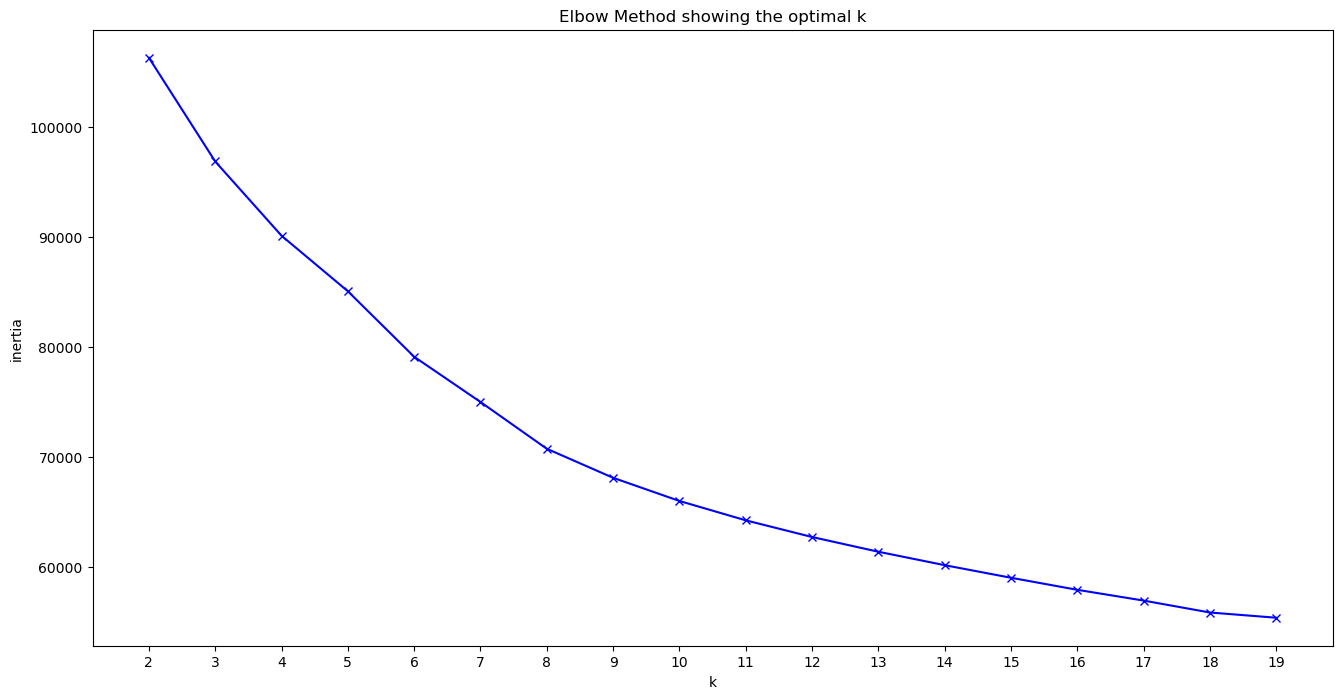

In [20]:
import numpy as np
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

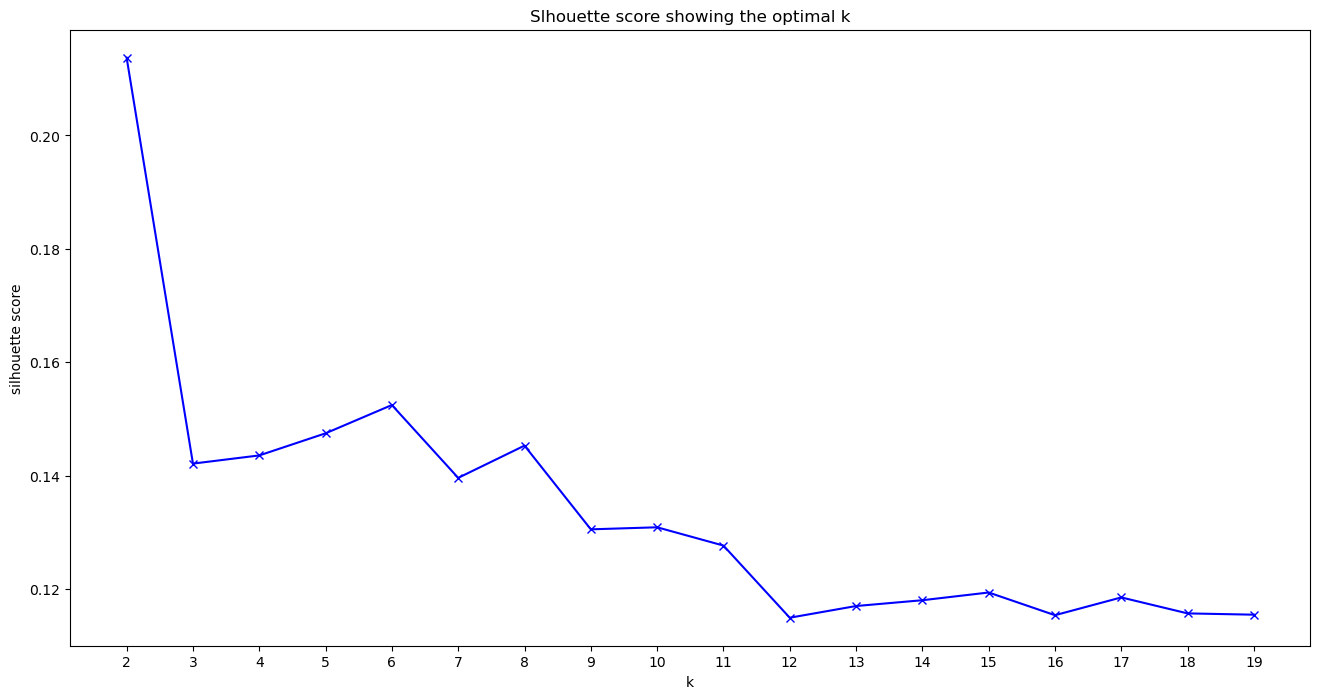

In [21]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(X_prep)

C:\Users\Alex\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=1234)

In [23]:
clusters = kmeans.predict(X_prep)

# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0     619
1    2921
2     498
3    2398
4    2021
5     844
6    1732
7     738
Name: count, dtype: int64

In [24]:
clusters

array([4, 6, 4, ..., 1, 1, 0])

In [25]:
data["cluster"]=clusters

In [26]:
data

,song_name,name,song_id,popularity,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,cluster
0,2K,Nosaj Thing,33xMbeHzmWd6Od0BmLZEUs,0,0.310,0.445,7,-13.355,0,0.0863,...,0.122,95.360,audio_features,33xMbeHzmWd6Od0BmLZEUs,spotify:track:33xMbeHzmWd6Od0BmLZEUs,https://api.spotify.com/v1/tracks/33xMbeHzmWd6...,https://api.spotify.com/v1/audio-analysis/33xM...,152560,3,4
1,4 Billion Souls,The Doors,3UnyplmZaq547hwsfOR5yy,26,0.419,0.565,5,-11.565,1,0.0347,...,0.648,151.277,audio_features,3UnyplmZaq547hwsfOR5yy,spotify:track:3UnyplmZaq547hwsfOR5yy,https://api.spotify.com/v1/tracks/3UnyplmZaq54...,https://api.spotify.com/v1/audio-analysis/3Uny...,197707,4,6
2,4 Minute Warning,Radiohead,1w8QCSDH4QobcQeT4uMKLm,0,0.354,0.302,9,-13.078,1,0.0326,...,0.223,123.753,audio_features,1w8QCSDH4QobcQeT4uMKLm,spotify:track:1w8QCSDH4QobcQeT4uMKLm,https://api.spotify.com/v1/tracks/1w8QCSDH4Qob...,https://api.spotify.com/v1/audio-analysis/1w8Q...,244285,4,4
3,7 Element,Vitas,7J9mBHG4J2eIfDAv5BehKA,0,0.727,0.785,5,-6.707,0,0.0603,...,0.960,129.649,audio_features,7J9mBHG4J2eIfDAv5BehKA,spotify:track:7J9mBHG4J2eIfDAv5BehKA,https://api.spotify.com/v1/tracks/7J9mBHG4J2eI...,https://api.spotify.com/v1/audio-analysis/7J9m...,249940,4,3
4,#9 Dream,R.E.M.,1VZedwJj1gyi88WFRhfThb,6,0.571,0.724,0,-5.967,1,0.0260,...,0.385,116.755,audio_features,1VZedwJj1gyi88WFRhfThb,spotify:track:1VZedwJj1gyi88WFRhfThb,https://api.spotify.com/v1/tracks/1VZedwJj1gyi...,https://api.spotify.com/v1/audio-analysis/1VZe...,278320,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11766,London Calling - Remastered,The Clash,5jzma6gCzYtKB1DbEwFZKH,75,0.651,0.801,0,-7.340,1,0.0514,...,0.776,133.769,audio_features,5jzma6gCzYtKB1DbEwFZKH,spotify:track:5jzma6gCzYtKB1DbEwFZKH,https://api.spotify.com/v1/tracks/5jzma6gCzYtK...,https://api.spotify.com/v1/audio-analysis/5jzm...,200480,4,1
11767,Low Rider,War,2fmMPJb5EzZCx8BcNJvVk4,0,0.811,0.647,0,-10.989,1,0.0498,...,0.990,139.787,audio_features,2fmMPJb5EzZCx8BcNJvVk4,spotify:track:2fmMPJb5EzZCx8BcNJvVk4,https://api.spotify.com/v1/tracks/2fmMPJb5EzZC...,https://api.spotify.com/v1/audio-analysis/2fmM...,191560,4,5
11768,Flower,Moby,60rIdEPDrzyLiLC0icp3xz,0,0.686,0.610,7,-5.902,1,0.0262,...,0.766,80.567,audio_features,60rIdEPDrzyLiLC0icp3xz,spotify:track:60rIdEPDrzyLiLC0icp3xz,https://api.spotify.com/v1/tracks/60rIdEPDrzyL...,https://api.spotify.com/v1/audio-analysis/60rI...,206293,4,1
11769,Brighter Than Gold,The Cat Empire,0sEm1ld0V8YTCPcjPVfIsc,47,0.711,0.718,6,-5.739,1,0.0380,...,0.688,117.071,audio_features,0sEm1ld0V8YTCPcjPVfIsc,spotify:track:0sEm1ld0V8YTCPcjPVfIsc,https://api.spotify.com/v1/tracks/0sEm1ld0V8YT...,https://api.spotify.com/v1/audio-analysis/0sEm...,200293,4,1


In [27]:
#look for song get song id / use song id to get audio feature / scale audio feature / use cluster pred fonction : which song cluster / recommand song for same cluster

In [28]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],
                                                           client_secret=secrets_dict['clientsecret']))

In [29]:
results = sp.search(q='Lady Gaga', limit=50)
results

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=Lady+Gaga&type=track&offset=0&limit=50',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1HY2Jd0NmPuamShAr6KMms'},
       'href': 'https://api.spotify.com/v1/artists/1HY2Jd0NmPuamShAr6KMms',
       'id': '1HY2Jd0NmPuamShAr6KMms',
       'name': 'Lady Gaga',
       'type': 'artist',
       'uri': 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'}],
     'available_markets': ['AR',
      'AU',
      'AT',
      'BE',
      'BO',
      'BR',
      'BG',
      'CA',
      'CL',
      'CO',
      'CR',
      'CY',
      'CZ',
      'DK',
      'DO',
      'DE',
      'EC',
      'EE',
      'SV',
      'FI',
      'FR',
      'GR',
      'GT',
      'HN',
      'HK',
      'HU',
      'IS',
      'IE',
      'IT',
      'LV',
      'LT',
      'LU',
      'MY',
      'MT',
      'MX',
      'NL',
      'NZ',
      'NI',
      'NO',
      'PA',
      'PY',
      'P

In [30]:
results["tracks"]["items"]

[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/1HY2Jd0NmPuamShAr6KMms'},
     'href': 'https://api.spotify.com/v1/artists/1HY2Jd0NmPuamShAr6KMms',
     'id': '1HY2Jd0NmPuamShAr6KMms',
     'name': 'Lady Gaga',
     'type': 'artist',
     'uri': 'spotify:artist:1HY2Jd0NmPuamShAr6KMms'}],
   'available_markets': ['AR',
    'AU',
    'AT',
    'BE',
    'BO',
    'BR',
    'BG',
    'CA',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DK',
    'DO',
    'DE',
    'EC',
    'EE',
    'SV',
    'FI',
    'FR',
    'GR',
    'GT',
    'HN',
    'HK',
    'HU',
    'IS',
    'IE',
    'IT',
    'LV',
    'LT',
    'LU',
    'MY',
    'MT',
    'MX',
    'NL',
    'NZ',
    'NI',
    'NO',
    'PA',
    'PY',
    'PE',
    'PH',
    'PL',
    'PT',
    'SG',
    'SK',
    'ES',
    'SE',
    'CH',
    'TW',
    'TR',
    'UY',
    'US',
    'GB',
    'AD',
    'LI',
    'MC',
    'ID',
    'JP',
    'TH',
    'VN',
    '

In [31]:
import pandas as pd
from pandas import json_normalize
pd.set_option("display.max_columns", 0)

def songRecommendFromBigList(songname):

#Initialize SpotiPy with user credentials
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['clientid'],client_secret=secrets_dict['clientsecret']))
    results = sp.search(q=songname, limit=50)
    results                                                     
    tracks = json_normalize(results["tracks"]["items"])
    artist_df = pd.DataFrame(columns=['href', 'id', 'name', 'type', 'uri', 'external_urls.spotify', 'song_id'])
    for i in tracks.index:
        artists_for_song = json_normalize(tracks.iloc[i]['artists'])
        artists_for_song['song_id'] = tracks.iloc[i]['id']            # we keep song id, it is the same for all the artists on the song
        artists_for_song['song_name'] = tracks.iloc[i]['name']        # same for song_name
        artists_for_song['popularity'] = tracks.iloc[i]['popularity'] # and for popularity   
        artist_df = pd.concat([artist_df, artists_for_song], axis=0)
    artist_df
    df_final = artist_df[['song_name', 'name', 'song_id', 'popularity']]
    #display(df_final)


    single_song_id=df_final.iloc[0,:][2]   
    sp.audio_features(single_song_id)[0]
    single_df=pd.DataFrame(sp.audio_features(single_song_id)[0],index=[0])
    #display(single_df)

    predict_single=single_df[['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'liveness', 'tempo','key', 'mode', 'valence']]
    predict_single

    transformed=scaler.transform(predict_single)

    song_cluster=kmeans.predict(transformed)[0]
    print(song_cluster)


    #songrecommendation from the same cluster
    random_song_cluster = data[data['cluster'] == song_cluster].sample(n=1)
    display(random_song_cluster)

In [32]:
# Read the CSV file into a DataFrame
df = pd.read_csv("your_repertoire_file.csv")
df

,position,title,artist_name
0,1,TEXAS HOLD 'EM,Beyoncé
1,2,Lose Control,Teddy Swims
2,3,Beautiful Things,Benson Boone
3,4,TEXAS HOLD 'EM,Beyoncé
4,5,dont let me go,mgk
...,...,...,...
95,96,Can't Get Enough,Jennifer Lopez
96,97,Unstoppable,Sia
97,98,Until I Found You (Em Beihold Version),Stephen Sanchez & Em Beihold
98,99,greedy,Tate McRae


# Function

In [33]:
 #Assuming your dataframe is named df
def recommend_song(df):
    title_input = input("Enter the song title: ").lower()
    if title_input in df['title'].str.lower().values:
        # Filter dataframe to exclude songs with the input title
        filtered_df = df[df['title'].str.lower() != title_input]
        # If there are still songs after filtering
        if len(filtered_df) > 0:
            # Select a random song from the filtered dataframe
            random_song = filtered_df.sample()
            recommended_song = random_song.iloc[0]['title']
            print(f"Recommendation: {recommended_song}")
    else:
        print("Spotify Recommendation:")
        songRecommendFromBigList(title_input)
        
recommend_song(df)

Enter the song title: greedy
Recommendation: ...Ready For It?
